In [2]:
# IMPORTING NECESSARY LIBRARIES 


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras_tuner import RandomSearch, HyperModel


In [3]:
# DATA LOADING


temperature_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\temperature.csv')
humidity_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\humidity.csv')
pressure_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\pressure.csv')
wind_speed_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\wind_speed.csv')
wind_direction_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\wind_direction.csv')

# Combine dataframes
combined_df = pd.concat([temperature_df, humidity_df, pressure_df, wind_speed_df, wind_direction_df], axis=1)


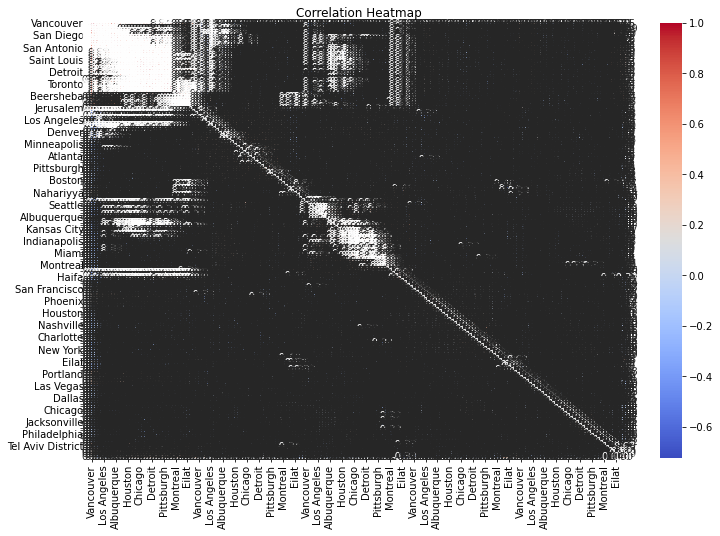

In [8]:
# Data Analysis and Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = combined_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [7]:
# DATA PREPROCESSING
non_numeric_columns = combined_df.select_dtypes(include=['object']).columns
for column in non_numeric_columns:
    try:
        combined_df[column] = pd.to_datetime(combined_df[column], errors='coerce')
        combined_df[column] = combined_df[column].astype('int64') // 10**9
    except (ValueError, TypeError, KeyError):
        combined_df.drop(columns=[column], inplace=True)

combined_df.fillna(method='ffill', inplace=True)
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Handle infinite values
combined_df.dropna(inplace=True)



C:\Users\HP\AppData\Local\Temp/ipykernel_23572/2703938517.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='ffill', inplace=True)


In [6]:

# FEATURE SCALING
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_df)
if np.isnan(scaled_features).any():
    print("NaN values detected after scaling. Check for infinite values or columns without variance.")
else:
    print("Scaling successful without NaN values.")

NaN values detected after scaling. Check for infinite values or columns without variance.


In [9]:
# SPLITTING DATA AND PREPARING GENERATORS


# Defining the total number of data and split point for training and validation
total_samples = scaled_features.shape[0]
train_size = int(total_samples * 0.8)  # 80% for training

# Assuming the target is the last column
targets = scaled_features[:, -1]

# Checking for NaN values in targets
print("Check for NaN values in targets:")
print(np.isnan(targets).sum())

# Ensuring there are no NaN values in targets
if np.isnan(targets).sum() > 0:
    print("NaN values detected in targets, handling NaN values.")
    targets = np.nan_to_num(targets)

train_features = scaled_features[:train_size]
train_targets = targets[:train_size]
validation_features = scaled_features[train_size:]
validation_targets = targets[train_size:]

train_generator = TimeseriesGenerator(train_features, train_targets, length=24, sampling_rate=1, batch_size=32)
validation_generator = TimeseriesGenerator(validation_features, validation_targets, length=24, sampling_rate=1, batch_size=32)


Check for NaN values in targets:
793
NaN values detected in targets, handling NaN values.


In [10]:
# DEFINING MODEL AND HYPERCLASS MODEL


def build_model(hp):
    model = Sequential([
        LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), input_shape=(24, scaled_features.shape[1])),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        return build_model(hp)

hypermodel = LSTMHyperModel(input_shape=(24, scaled_features.shape[1]))


In [11]:
# HYPERPARAMETER TUNING


tuner = RandomSearch(
    hypermodel,
    objective='val_mean_squared_error',
    max_trials=10,
    executions_per_trial=2,
    directory='tuning',
    project_name='lstm_tuning'
)

tuner.search(train_generator, validation_data=validation_generator, epochs=10, callbacks=[EarlyStopping(patience=3)])


Reloading Tuner from tuning\lstm_tuning\tuner0.json


In [12]:
# EVALUATION


best_model = tuner.get_best_models(num_models=1)[0]

# Evaluating the best model on the validation set
val_metrics = best_model.evaluate(validation_generator)
print(f'Validation Loss: {val_metrics[0]}')
print(f'Validation Mean Absolute Error: {val_metrics[1]}')
print(f'Validation Mean Squared Error: {val_metrics[2]}')


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


  8/283 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: nan - mean_absolute_error: nan - mean_squared_error: nan           

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/283 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: nan - mean_absolute_error: nan - mean_squared_error: nan

KeyboardInterrupt: 

283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


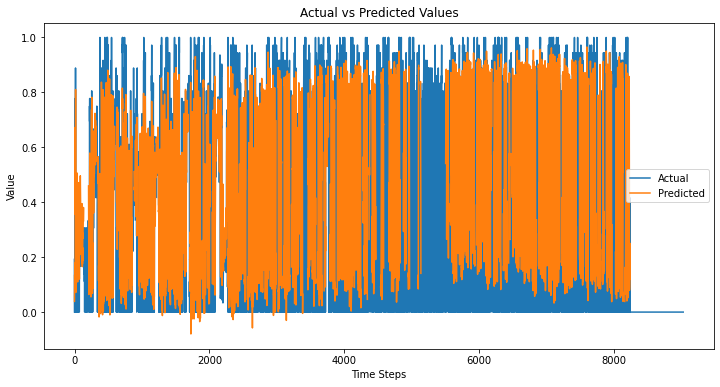

In [37]:
# MODEL PREDICTION 


predictions = best_model.predict(validation_generator)


# Reshape validation targets to match the predictions shape
validation_targets_reshaped = validation_targets[-predictions.shape[0]:]

plt.figure(figsize=(12, 6))
plt.plot(validation_targets_reshaped, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()


In [60]:
# Save the best model
best_model.save('best_lstm_model.h5')
